Автор: Лейман М.А.  
Дата создания: 14.06.2025 

# Итоговая аттестация 
### __проект 7:__   _Семантическая сегментация с помощью U-Net на уличных сценах_  



## DeepLab


## Импорты 

In [4]:
# from attestation import CityscapesFlatDataset, CityscapesFlatDataset2, merge_folders, train_model,\
#                         prepare_cityscapes_loaders, visualize_segmentation, emty_cache, visualize_image_and_mask, prediction_mask


from data.dataset import CityscapesFlatDataset, CityscapesFlatDataset2, prepare_cityscapes_loaders
from utils.utils import emty_cache, visualize_image_and_mask, visualize_segmentation
from model.train import train_model
from model.predict import prediction_mask

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' 
import warnings
import copy
import torch.optim as optim
import time
import numpy as np
import torch
from torch.utils.data import random_split, DataLoader
from torchsummary import summary
from tqdm import tqdm
from torch.optim import lr_scheduler
from matplotlib import rcParams
import shutil
from PIL import Image
from torch.utils.data import Dataset
import cv2
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
import gc

warnings.filterwarnings("ignore")
np.random.seed(42)
#set_global_seed(42)
rcParams['figure.figsize'] = (14,6)

## Параметры

In [5]:
# Классы
CITYSCAPES_PALETTE = np.array([
    [0, 0, 0],      # ФОН
    [128, 64,128],  # road
    [244, 35,232],  # sidewalk
    [70, 70, 70],   # building
    [102,102,156],  # wall
    [190,153,153],  # fence
    [153,153,153],  # pole
    [250,170, 30],  # traffic light
    [220,220,  0],  # traffic sign
    [107,142, 35],  # vegetation
    [152,251,152],  # terrain
    [70,130,180],   # sky
    [220, 20, 60],  # person
    [255,  0,  0],  # rider
    [0,  0,142],    # car
    [0,  0, 70],    # truck
    [0, 60,100],    # bus
    [0, 80,100],    # train
    [0,  0,230],    # motorcycle
    [119, 11, 32],  # bicycle
])


In [6]:
# устанавливаем device если gpu или cpu


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("работаем на устройстве: ", device)
print('Версия torch:           ', torch.__version__)
print("версия  cuDNN:          ", torch.backends.cudnn.version())

# ПРОВЕРКА GPU
!nvidia-smi

работаем на устройстве:  cuda
Версия torch:            2.7.1+cu126
версия  cuDNN:           90501
Tue Jun 24 14:34:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        Off |   00000000:01:00.0  On |                  N/A |
|  0%   48C    P8             22W /  170W |    2041MiB /  12288MiB |     22%      Default |
|                                         

## Загрузка данных 

### Датасет

In [7]:
# Путь к папкам с исходными данными
images_root = './dataset/images'
targets_root = './dataset/targets'

# Папки для объединённых данных
images_merged = './dataset/images_merged'
targets_merged = './dataset/targets_merged'

# merge_folders(images_root, images_merged)
# merge_folders(targets_root, targets_merged)


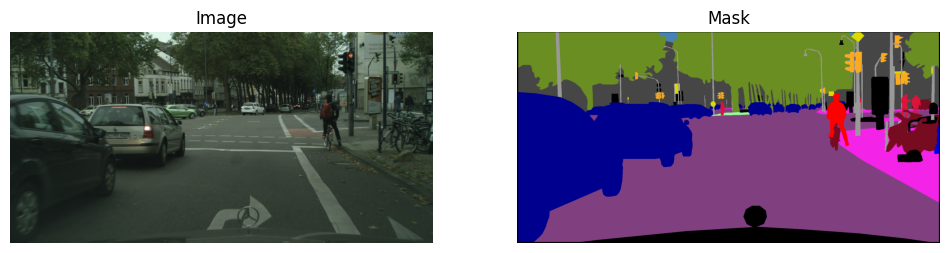

In [ ]:
# Загрузка с PIL
root_dir = './dataset'
dataset = CityscapesFlatDataset(root_dir)
image, mask = dataset[10]
visualize_image_and_mask(image, mask, class_palette=CITYSCAPES_PALETTE)

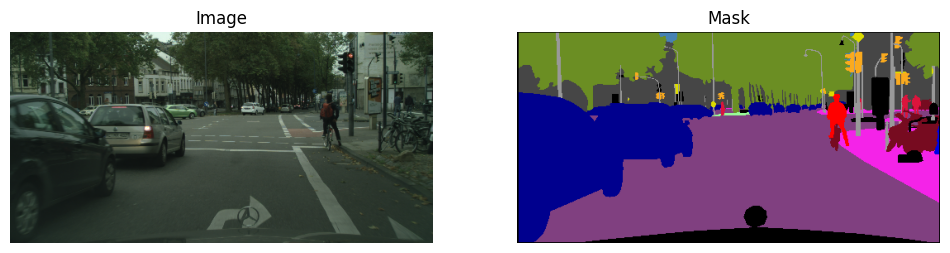

In [ ]:
# Загрузка с OpenCV
root_dir = './dataset'
dataset = CityscapesFlatDataset2(root_dir)
image, mask = dataset[10]

visualize_image_and_mask(image, mask, class_palette=CITYSCAPES_PALETTE)

In [7]:
print(np.unique(mask))


[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 18 19]


### Разделение датасета

In [10]:
batch_size = 16
size = 256, 512

train_loader, val_loader, train_dataset, val_dataset = prepare_cityscapes_loaders(
            CityscapesFlatDataset2, './dataset', size, batch_size=batch_size
        )

# Размеры тензоров
for images, masks in train_loader:
    print(images.shape)  # [batch_size, 3, H, W]
    print(masks.shape)   # [batch_size, 1, H, W]
    masks = masks.squeeze(1)  # [batch_size, H, W]
    break



Train size: 2780, Validation size: 695
torch.Size([16, 3, 256, 512])
torch.Size([16, 256, 512])


## Модели

### 2) __DeepLabV3Plus__  

In [12]:
import segmentation_models_pytorch as smp
import torch

# Параметры модели
ENCODER = "resnet34"           # можно выбрать другой, например 'resnet50'
ENCODER_WEIGHTS = "imagenet"   # предобученные веса энкодера
CLASSES = 20                   # количество классов сегментации (например, для Cityscapes)
ACTIVATION = None              # активация на выходе (например, 'softmax' или None)

# Создаем модель DeepLabV3+
model_deeplab = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=CLASSES,
    activation=ACTIVATION,
)


## Обучение

### 2) DeepLabV3Plus

Epoch 1 Val: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it, acc=0.852, iou=0.455, loss=0.419]


Epoch 1 summary: Train Loss: 0.2892, Acc: 0.9069, IoU: 0.5375 | Val Loss: 0.4777, Acc: 0.8605, IoU: 0.4245
Сохранена лучшая модель 1 с val IoU: 0.4245


Epoch 2 Val: 100%|██████████| 44/44 [00:48<00:00,  1.09s/it, acc=0.891, iou=0.479, loss=0.403]


Epoch 2 summary: Train Loss: 0.2914, Acc: 0.9060, IoU: 0.5318 | Val Loss: 0.3446, Acc: 0.8920, IoU: 0.4606
Сохранена лучшая модель 2 с val IoU: 0.4606


Epoch 3 Val: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it, acc=0.897, iou=0.426, loss=0.411]


Epoch 3 summary: Train Loss: 0.2677, Acc: 0.9107, IoU: 0.5519 | Val Loss: 0.3339, Acc: 0.8970, IoU: 0.4662
Сохранена лучшая модель 3 с val IoU: 0.4662


Epoch 4 Val: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it, acc=0.889, iou=0.421, loss=0.394]


Epoch 4 summary: Train Loss: 0.2515, Acc: 0.9160, IoU: 0.5729 | Val Loss: 0.3660, Acc: 0.8898, IoU: 0.4690
Сохранена лучшая модель 4 с val IoU: 0.4690


Epoch 5 Val: 100%|██████████| 44/44 [00:47<00:00,  1.08s/it, acc=0.892, iou=0.384, loss=0.411]


Epoch 5 summary: Train Loss: 0.2640, Acc: 0.9151, IoU: 0.5661 | Val Loss: 0.3611, Acc: 0.8916, IoU: 0.4525


Epoch 6 Val: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it, acc=0.905, iou=0.424, loss=0.392]


Epoch 6 summary: Train Loss: 0.2239, Acc: 0.9210, IoU: 0.5965 | Val Loss: 0.3100, Acc: 0.9060, IoU: 0.4950
Сохранена лучшая модель 6 с val IoU: 0.4950


Epoch 7 Val: 100%|██████████| 44/44 [00:48<00:00,  1.09s/it, acc=0.906, iou=0.451, loss=0.401]


Epoch 7 summary: Train Loss: 0.2055, Acc: 0.9301, IoU: 0.6182 | Val Loss: 0.3116, Acc: 0.9064, IoU: 0.5008
Сохранена лучшая модель 7 с val IoU: 0.5008


Epoch 8 Val: 100%|██████████| 44/44 [00:47<00:00,  1.08s/it, acc=0.907, iou=0.464, loss=0.378]


Epoch 8 summary: Train Loss: 0.1978, Acc: 0.9327, IoU: 0.6298 | Val Loss: 0.3121, Acc: 0.9066, IoU: 0.5051
Сохранена лучшая модель 8 с val IoU: 0.5051


Epoch 9 Val: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it, acc=0.907, iou=0.481, loss=0.378]


Epoch 9 summary: Train Loss: 0.1946, Acc: 0.9342, IoU: 0.6314 | Val Loss: 0.3132, Acc: 0.9079, IoU: 0.4977


Epoch 10 Val: 100%|██████████| 44/44 [00:48<00:00,  1.09s/it, acc=0.907, iou=0.46, loss=0.379] 


Epoch 10 summary: Train Loss: 0.1896, Acc: 0.9352, IoU: 0.6417 | Val Loss: 0.3173, Acc: 0.9078, IoU: 0.5028


Epoch 11 Val: 100%|██████████| 44/44 [00:48<00:00,  1.09s/it, acc=0.907, iou=0.46, loss=0.384] 


Epoch 11 summary: Train Loss: 0.1829, Acc: 0.9369, IoU: 0.6463 | Val Loss: 0.3153, Acc: 0.9072, IoU: 0.5035


Epoch 12 Val: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it, acc=0.907, iou=0.462, loss=0.382]


Epoch 12 summary: Train Loss: 0.1790, Acc: 0.9395, IoU: 0.6507 | Val Loss: 0.3175, Acc: 0.9074, IoU: 0.5044


Epoch 13 Val: 100%|██████████| 44/44 [00:48<00:00,  1.09s/it, acc=0.907, iou=0.461, loss=0.385]


Epoch 13 summary: Train Loss: 0.1790, Acc: 0.9387, IoU: 0.6538 | Val Loss: 0.3187, Acc: 0.9078, IoU: 0.5009


Epoch 14 Val: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it, acc=0.908, iou=0.462, loss=0.388]


Epoch 14 summary: Train Loss: 0.1777, Acc: 0.9396, IoU: 0.6555 | Val Loss: 0.3210, Acc: 0.9080, IoU: 0.5055
Сохранена лучшая модель 14 с val IoU: 0.5055


Epoch 15 Val: 100%|██████████| 44/44 [00:48<00:00,  1.09s/it, acc=0.908, iou=0.464, loss=0.384]


Epoch 15 summary: Train Loss: 0.1781, Acc: 0.9385, IoU: 0.6534 | Val Loss: 0.3183, Acc: 0.9083, IoU: 0.5039


Epoch 16 Val: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it, acc=0.907, iou=0.461, loss=0.392]


Epoch 16 summary: Train Loss: 0.1728, Acc: 0.9403, IoU: 0.6588 | Val Loss: 0.3206, Acc: 0.9078, IoU: 0.5045


Epoch 17 Val: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it, acc=0.907, iou=0.462, loss=0.392]


Epoch 17 summary: Train Loss: 0.1728, Acc: 0.9400, IoU: 0.6614 | Val Loss: 0.3212, Acc: 0.9077, IoU: 0.5041


Epoch 18 Val: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it, acc=0.907, iou=0.462, loss=0.389]


Epoch 18 summary: Train Loss: 0.1717, Acc: 0.9399, IoU: 0.6597 | Val Loss: 0.3215, Acc: 0.9080, IoU: 0.5044


Epoch 19 Val: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it, acc=0.908, iou=0.461, loss=0.39] 


Epoch 19 summary: Train Loss: 0.1726, Acc: 0.9407, IoU: 0.6607 | Val Loss: 0.3214, Acc: 0.9079, IoU: 0.5027


Epoch 20 Val: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it, acc=0.908, iou=0.461, loss=0.391]


Epoch 20 summary: Train Loss: 0.1701, Acc: 0.9410, IoU: 0.6657 | Val Loss: 0.3222, Acc: 0.9080, IoU: 0.5038


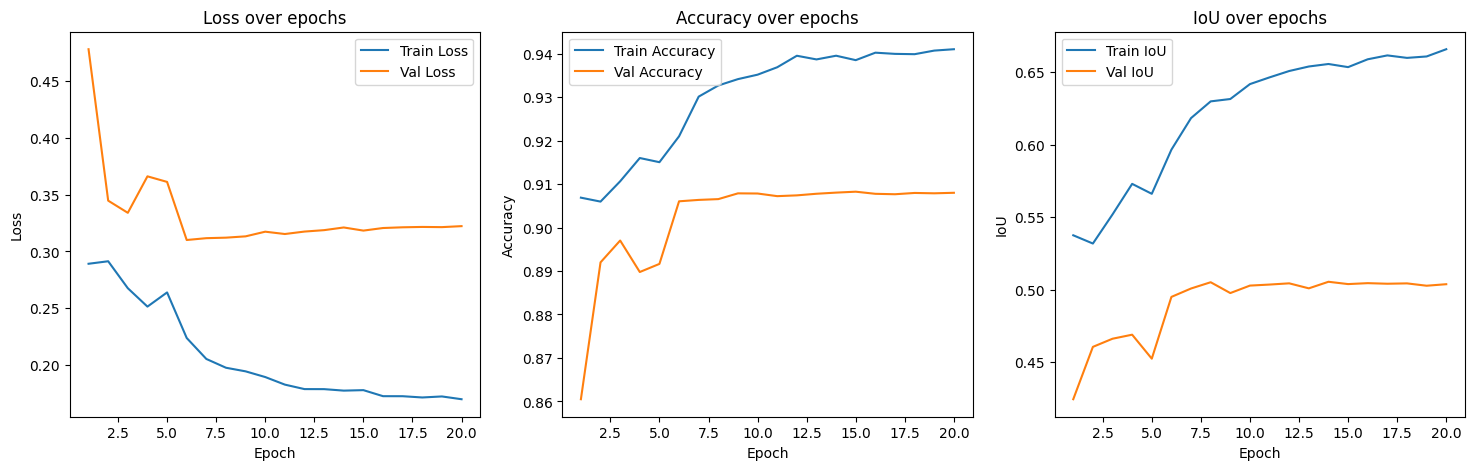

In [15]:
model_deeplab.load_state_dict(torch.load('models/deeplab_model2.pth', map_location=torch.device('cpu'))) 
emty_cache()
optimizer = torch.optim.Adam(model_deeplab.parameters(), lr=0.0003)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)




train_model(model_deeplab, train_loader, val_loader, optimizer, device, num_epochs=20, scheduler=scheduler, save_path='models/deeplab_model2.pth')

## Использование модели

In [16]:
model_deeplab.load_state_dict(torch.load('models/deeplab_model2.pth', map_location=torch.device(device))) 
model_deeplab.eval();
model_deeplab = model_deeplab.to(device)
path_img = './dataset/images2/train/hamburg/hamburg_000000_008494_leftImg8bit.png'


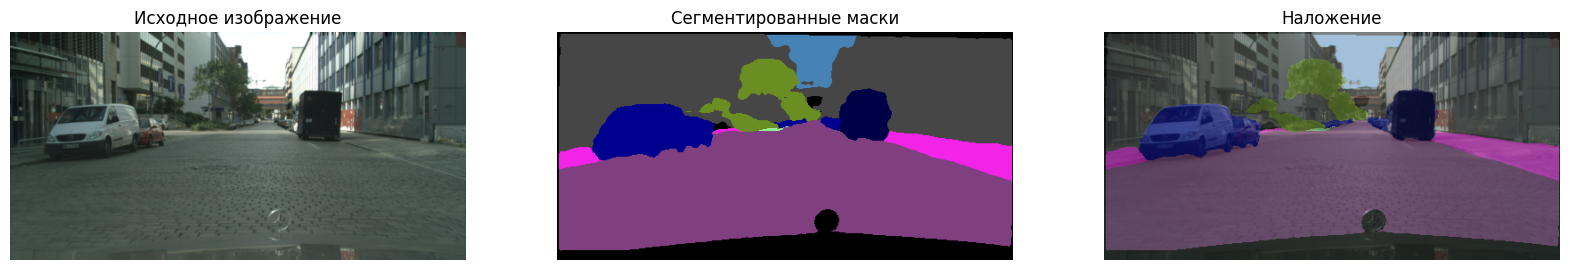

In [17]:
img, prediction = prediction_mask(path_img, model_deeplab)
visualize_segmentation(img, prediction, CITYSCAPES_PALETTE)